#  Predicting disaster tweets using LSTM
bold text

## **Tasks**:
1- Load the dataset

2- Check head and info of the data

3- Is there a missing data [how many and the percentage if there]? 

4- How many data in each class?

5- Get the top 15 locations of the data 

6- Get the top 15 keyword in the data 

7- What are the most common words?

8- What are the most common stop words?

9- Use nlp to prepare dataset [tokenization, pad sequence, etc.] 

10- Prepare train, test sets

11- Train your LSTM structure

12- Evaluate the model and make predictions

13- Evaluate the results with charts of acc and loss

14- Save your model

15- Post your project into GitHub

##**Description**
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

###***Libraries***

In [45]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
import string 
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout , Bidirectional
from tensorflow.keras.utils import plot_model
from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [46]:
#read data
train = pd.read_csv("/train.csv")

In [47]:
train.head()  

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [49]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [50]:
#Is there a missing data [how many and the percentage if there]?
is_null =train.isnull().sum()
is_null


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [51]:
#percentage of missing_data (location)
is_null_perc_location= (is_null.location * 100)/train.shape[0]
is_null_perc_location

33.27203467752528

In [52]:
##percentage of missing_data (keyword)
is_null_perc_keyword= (is_null.keyword * 100)/train.shape[0]
is_null_perc_keyword

0.8012610009194798

In [53]:
#How many data in each class?
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

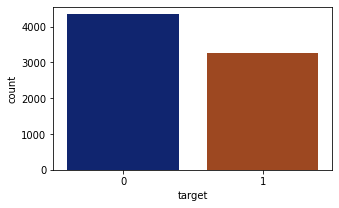

In [54]:
plt.figure(figsize=(5,3))
sns.countplot(x = 'target', data=train , palette= "dark");

In [55]:
locations = train["location"].value_counts()
locations

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

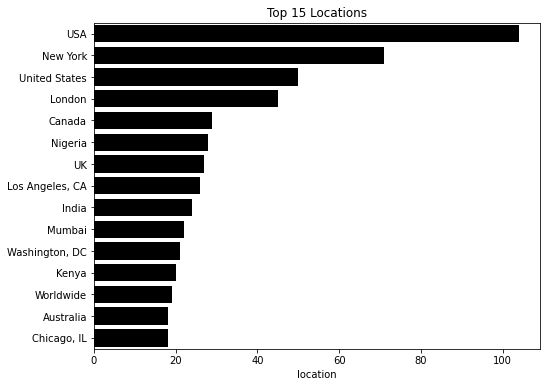

In [56]:
plt.figure(figsize=(8,6))
sns.barplot(y=locations[0:15].index, x=locations[0:15] , orient='h' , color = "black")
plt.title("Top 15 Locations");

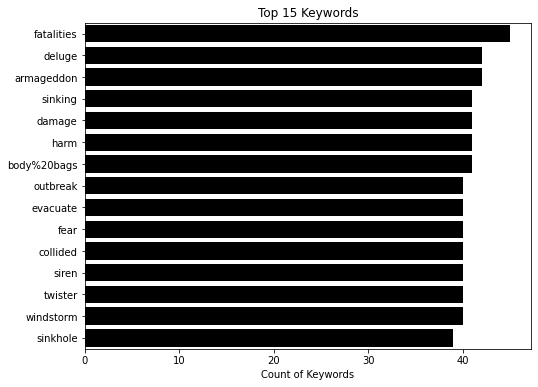

In [57]:
filter = train['keyword'].value_counts()[:15]
plt.figure(figsize=(8,6))
sns.barplot( x = filter ,y = filter.index, color = "black")
plt.title("Top 15 Keywords")
plt.xlabel("Count of Keywords");

In [58]:
#visualize the length of each statement
train["length"]  = train["text"].apply(len)
train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


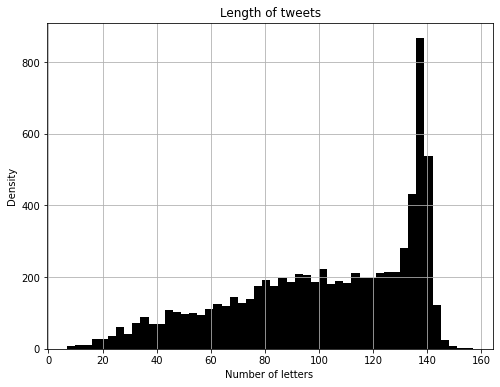

In [59]:
train["length"].hist( figsize=(8,6) , bins=50, color ='black')
plt.title("Length of tweets")
plt.xlabel("Number of letters ")
plt.ylabel("Density");

In [60]:
#remove punctuation
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [61]:
train['clean_text'] = train['text'].apply(clean_text)
train['clean_text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: clean_text, dtype: object

In [62]:
train.head()

,id,keyword,location,text,target,length,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfires evacuation orders in...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,just got sent this photo from ruby alaska as s...


In [63]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_word = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
#What are the most common words?
stop_word

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [65]:
def common_stopwords(text):
    common_stopword = [word for word in text.split() if word.lower() in stopwords.words('english')]
    return common_stopword
train['common_stopwords'] = train['clean_text'].apply(common_stopwords)
train['common_stopwords']

0                          [our, are, the, of, this, all]
1                                                      []
2       [all, to, in, are, being, by, no, other, or, i...
3                                                    [in]
4                   [just, this, from, as, from, into, a]
                              ...                        
7608                                            [a, into]
7609           [the, out, of, in, in, the, of, the, very]
7610                                              [s, of]
7611                             [after, an, with, a, in]
7612                                      [the, more, by]
Name: common_stopwords, Length: 7613, dtype: object

In [66]:
c_stopwords=[]
for i in train['common_stopwords']:
    for j in i:
      c_stopwords.append(j)

In [67]:
comm_stopwords = pd.DataFrame (c_stopwords)
stopwords_filter = comm_stopwords.value_counts()[:15]
stopwords_filter

the     3248
a       2167
in      1971
to      1943
of      1821
and     1410
i       1363
is       942
for      889
on       850
you      787
my       672
with     572
it       560
that     559
dtype: int64

In [ ]:
def removingstopword(text):
    restopword = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return restopword
train['clean_text'] = train['clean_text'].apply(removingstopword)

In [69]:
train.clean_text

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [people, receive, wildfires, evacuation, order...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610                                    [volcano, hawaii]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: clean_text, Length: 7613, dtype: object

In [70]:
#Use nlp to prepare dataset [tokenization, pad sequence, etc.] 
tokenizer = Tokenizer(num_words = 3000 ,split=' ')
tokenizer.fit_on_texts(train.clean_text.values) 
x = tokenizer.texts_to_sequences(train['clean_text'].values) 
X = pad_sequences(x)

In [71]:
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =42)
lstm = 32
model = Sequential()
model.add(Embedding(3000 , 32 , input_length = X.shape[1]))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(lstm, dropout=0.5 , recurrent_dropout=0.4)))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 19, 32)            96000     
                                                                 
 dropout_1 (Dropout)         (None, 19, 32)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 112,705
Trainable params: 112,705
Non-trainable params: 0
_________________________________________________________________
None


In [72]:
X_test

array([[   0,    0,    0, ...,  198,  159,  263],
       [   0,    0,    0, ...,  290,   34, 1543],
       [   0,    0,    0, ..., 2840,   16, 2481],
       ...,
       [   0,    0,    0, ...,   23,  124,    7],
       [   0,    0,    0, ...,  167,  166,  196],
       [   0,    0,    0, ...,  836,   21,  286]], dtype=int32)

In [ ]:
m_stat = model.fit(X_train, y_train, epochs = 20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
191/191 [==============================] - 15s 45ms/step - loss: 0.5697 - accuracy: 0.6911 - val_loss: 0.4468 - val_accuracy: 0.7971
Epoch 2/20
191/191 [==============================] - 8s 42ms/step - loss: 0.3969 - accuracy: 0.8269 - val_loss: 0.4511 - val_accuracy: 0.7991
Epoch 3/20
191/191 [==============================] - 8s 41ms/step - loss: 0.3509 - accuracy: 0.8525 - val_loss: 0.4789 - val_accuracy: 0.7827
Epoch 4/20
191/191 [==============================] - 8s 42ms/step - loss: 0.3213 - accuracy: 0.8654 - val_loss: 0.5009 - val_accuracy: 0.7827
Epoch 5/20
191/191 [==============================] - 8s 41ms/step - loss: 0.3007 - accuracy: 0.8791 - val_loss: 0.5338 - val_accuracy: 0.7820
Epoch 6/20
191/191 [==============================] - 8s 41ms/step - loss: 0.2905 - accuracy: 0.8810 - val_loss: 0.5098 - val_accuracy: 0.7768
Epoch 7/20
191/191 [==============================] - 8s 41ms/step - loss: 0.2764 - accuracy: 0.8857 - val_loss: 0.6023 - val_accuracy: 0.772

In [ ]:
plt.plot(m_stat.history['accuracy'])
plt.plot(m_stat.history['val_accuracy'])
plt.title(' m_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

In [ ]:
plt.plot(m_stat.history['loss'])
plt.plot(m_stat.history['val_loss'])
plt.title('m_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

In [ ]:
y_pred = model.predict(X_test).round()
y_pred

In [ ]:
train_accuracy_score = (metrics.accuracy_score(y_train,model.predict(X_train).round())*100)
train_accuracy_score

In [ ]:
print('Accuracy  is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Recall  is    : ', (metrics.recall_score(y_test, y_pred)))
print('Precision  is : ', (metrics.precision_score(y_test, y_pred)))

## Loading Test Data

In [ ]:
test = pd.read_csv('/test.csv')
test.head()

In [ ]:
test['clean_text'] = test['text'].apply(clean_text)
test['clean_text'] = test['clean_text'].apply(removingstopword)
test.head()

In [ ]:
tokenizer_test = Tokenizer(num_words = 3000 ,split=' ')
tokenizer_test.fit_on_texts(test.clean_text.values) 
t_test = tokenizer_test.texts_to_sequences(test['clean_text'].values) 
X_test = pad_sequences(t_test)

In [ ]:
X_test

In [ ]:
X_test.resize(3263,19,refcheck=False)

In [ ]:
y_pred = model.predict(X_test).round()
y_pred

14- Save the model

In [ ]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load("model.pkl")